# **Load libraries**

In [34]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.inspection import DecisionBoundaryDisplay

In [35]:
sns.set_palette('viridis')
sns.color_palette(palette='viridis')

[(0.275191, 0.194905, 0.496005),
 (0.212395, 0.359683, 0.55171),
 (0.153364, 0.497, 0.557724),
 (0.122312, 0.633153, 0.530398),
 (0.288921, 0.758394, 0.428426),
 (0.626579, 0.854645, 0.223353)]

# **Load Dataset**

In [36]:
df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "neuromusic/avocado-prices",
  "avocado.csv"
)

Using Colab cache for faster access to the 'avocado-prices' dataset.


# **Analyse and Preprocess Dataset**

Some relevant columns in the dataset:

*   Date - The date of the observation
*   AveragePrice - the average price of a single avocado
type - conventional or organic
*   year - the year
*   Region - the city or region of the observation
*   Total Volume - Total number of avocados sold
*   4046 - Total number of avocados with PLU 4046 sold
*   4225 - Total number of avocados with PLU 4225 sold
*   4770 - Total number of avocados with PLU 4770 sold

In [ ]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [38]:
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [39]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          18249 non-null  datetime64[ns]
 1   AveragePrice  18249 non-null  float64       
 2   Total Volume  18249 non-null  float64       
 3   4046          18249 non-null  float64       
 4   4225          18249 non-null  float64       
 5   4770          18249 non-null  float64       
 6   Total Bags    18249 non-null  float64       
 7   Small Bags    18249 non-null  float64       
 8   Large Bags    18249 non-null  float64       
 9   XLarge Bags   18249 non-null  float64       
 10  type          18249 non-null  object        
 11  year          18249 non-null  int64         
 12  region        18249 non-null  object        
dtypes: datetime64[ns](1), float64(9), int64(1), object(2)
memory usage: 1.8+ MB


*Some encoding(Who knows, maybe the price is affected by the region?)*

In [41]:
encoder = OneHotEncoder(sparse_output=False)

encoded = encoder.fit_transform(df[['region']])

encoded_df = pd.DataFrame(
    encoded,
    columns=encoder.get_feature_names_out(['region']),
    index=df.index
)

df = pd.concat([df, encoded_df], axis=1)
df.drop('region', axis=1, inplace=True)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 66 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        18249 non-null  datetime64[ns]
 1   AveragePrice                18249 non-null  float64       
 2   Total Volume                18249 non-null  float64       
 3   4046                        18249 non-null  float64       
 4   4225                        18249 non-null  float64       
 5   4770                        18249 non-null  float64       
 6   Total Bags                  18249 non-null  float64       
 7   Small Bags                  18249 non-null  float64       
 8   Large Bags                  18249 non-null  float64       
 9   XLarge Bags                 18249 non-null  float64       
 10  type                        18249 non-null  object        
 11  year                        18249 non-null  int64     

# **Choosing features**

As we will use classifier, I will take type as a target for classification.

In [43]:
df_corr = df

df_corr['type'] = df_corr['type'].map({'conventional': 0, 'organic': 1})

df_corr = pd.DataFrame(np.abs(df_corr.corr())).sort_values('type', ascending=False)['type']

df_corr

,type
type,1.000000
AveragePrice,0.615845
Total Volume,0.232434
4225,0.232289
4046,0.225819
...,...
region_GrandRapids,0.000023
region_Columbus,0.000023
region_LosAngeles,0.000023
region_Chicago,0.000023


Top by abs. corr. are: AveragePrice and Total Volume.

# **Decision Boundary Graph**

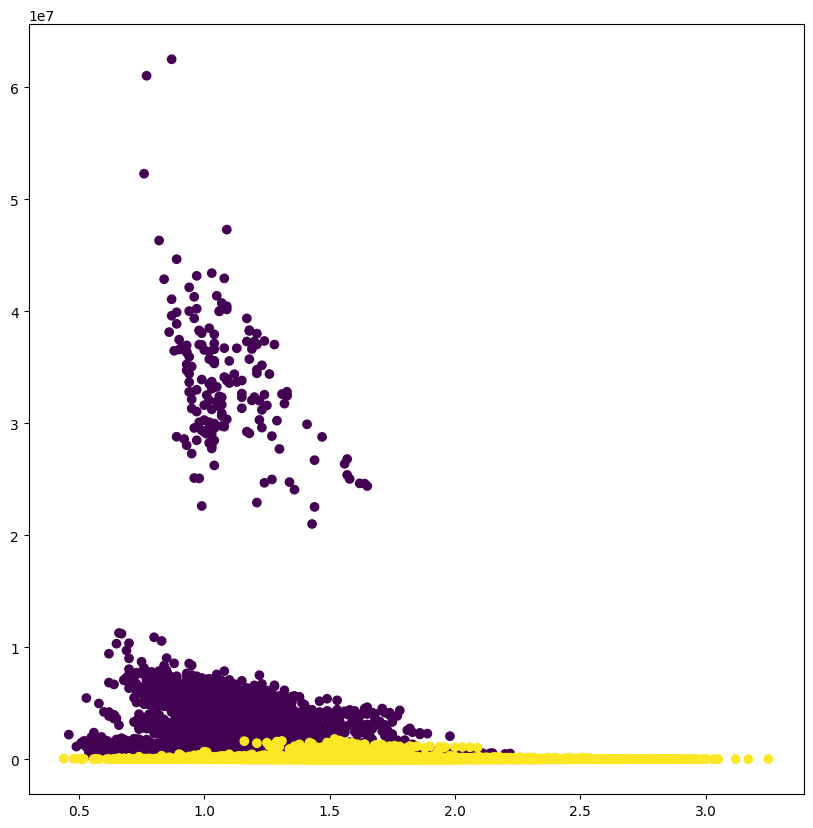

In [44]:
plt.figure(figsize=(10,10))
plt.scatter(x="AveragePrice", y="Total Volume", c=df['type'], data=df)
plt.show()

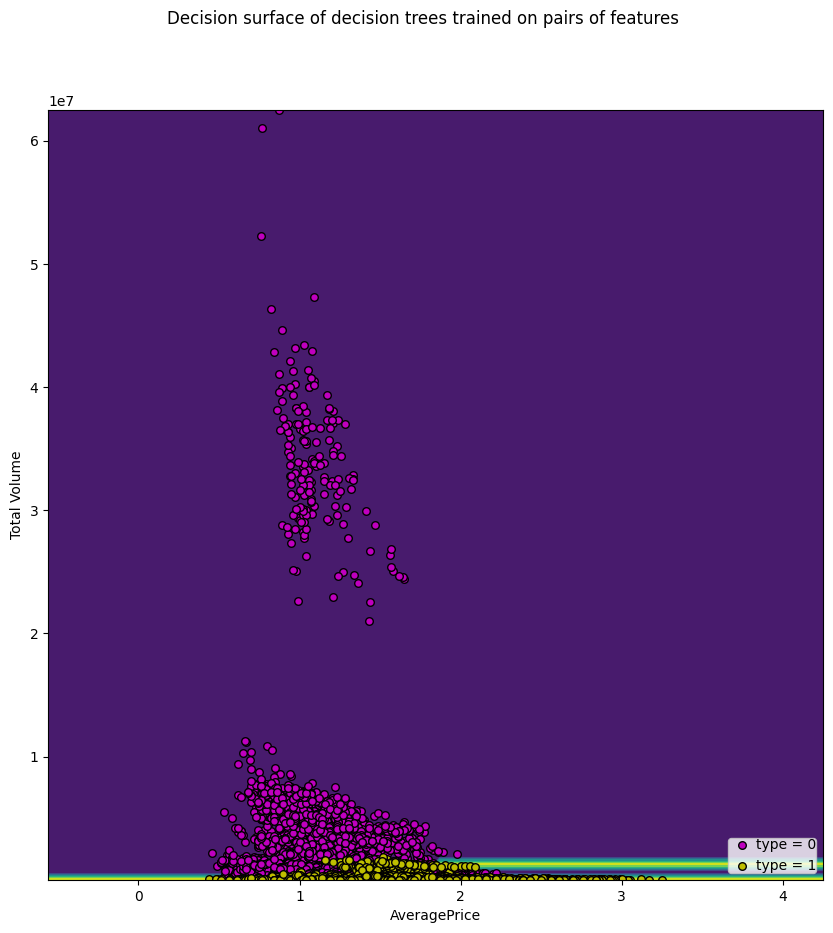

In [45]:
fig, ax = plt.subplots(figsize=(10, 10))

n_classes = df['type'].nunique()
plot_colors = "myg"
plot_step = 0.02

X = df[['AveragePrice', 'Total Volume']]
y = df['type']

# Train
clf = DecisionTreeClassifier().fit(X, y)

# Plot the decision boundary
DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    ax=ax,
    cmap='viridis',
    response_method="predict",
    xlabel='AveragePrice',
    ylabel='Total Volume',
)

# Plot the training points
for i, color in zip(range(n_classes), plot_colors):
    idx = (y == i)

    plt.scatter(
        X.loc[idx, 'AveragePrice'],
        X.loc[idx, 'Total Volume'],
        c=color,
        label=f"type = {i}",
        edgecolor="black",
        s=30,
    )


plt.suptitle("Decision surface of decision trees trained on pairs of features")
plt.legend(loc="lower right", borderpad=0, handletextpad=0)
plt.show()

The decision boundary is largely dominated by a single class, with only a narrow region predicting the alternative class. This behavior is caused by the strong imbalance in feature scales, where Total Volume spans several orders of magnitude compared to AveragePrice, leading the tree to prioritize splits along the volume axis. Additionally, the axis-aligned nature of decision trees results in rectangular decision regions rather than smooth boundaries. Overall, the plot indicates that the model relies primarily on Total Volume and doesn't really rely on AveragePrice.

# Split Dataset

In [46]:
df['type'].unique()

array([0, 1])

In [47]:
X = df.drop(['AveragePrice', 'Date'], axis=1)
y = df['AveragePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## max_depth

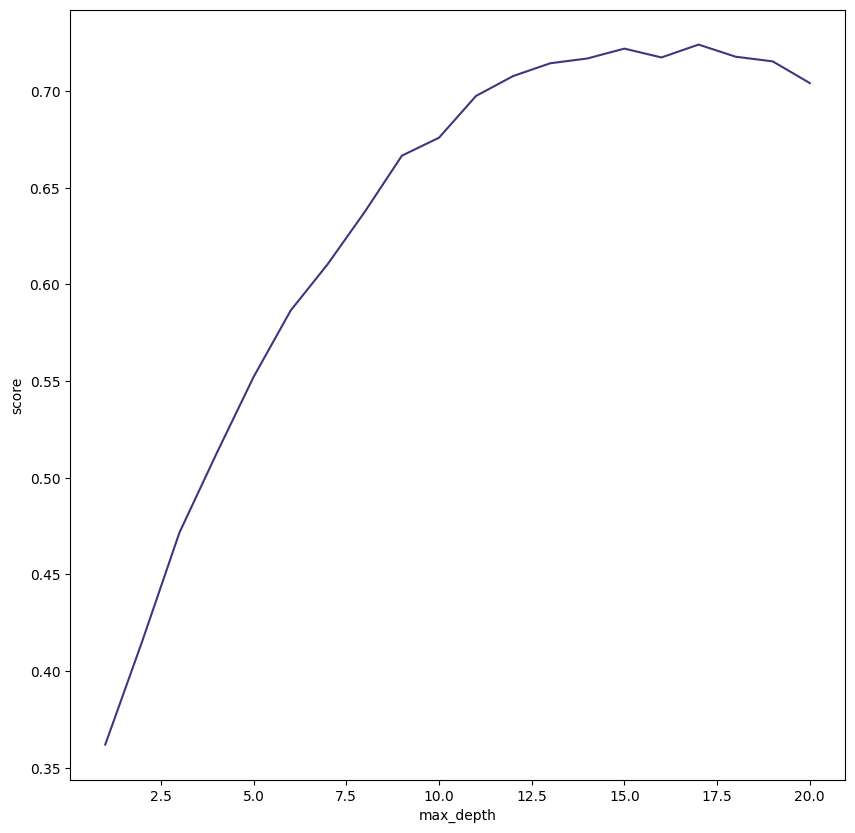

In [48]:
plt.figure(figsize=(10,10))

x_vals = range(1, 21)
y_vals = []

for i in x_vals:
  rgr = DecisionTreeRegressor(max_depth=i, random_state=42)
  rgr.fit(X_train, y_train)
  y_vals.append(rgr.score(X_test, y_test))

plt.plot(x_vals, y_vals)
plt.xlabel('max_depth')
plt.ylabel('score')
plt.show()

In [49]:
x_vals[y_vals.index(max(y_vals))]

17

It shows that the accuracy of the predictions is increasing as the max depth of the tree is increasing.

I'll take 13, because otherwise it is already overfitting.

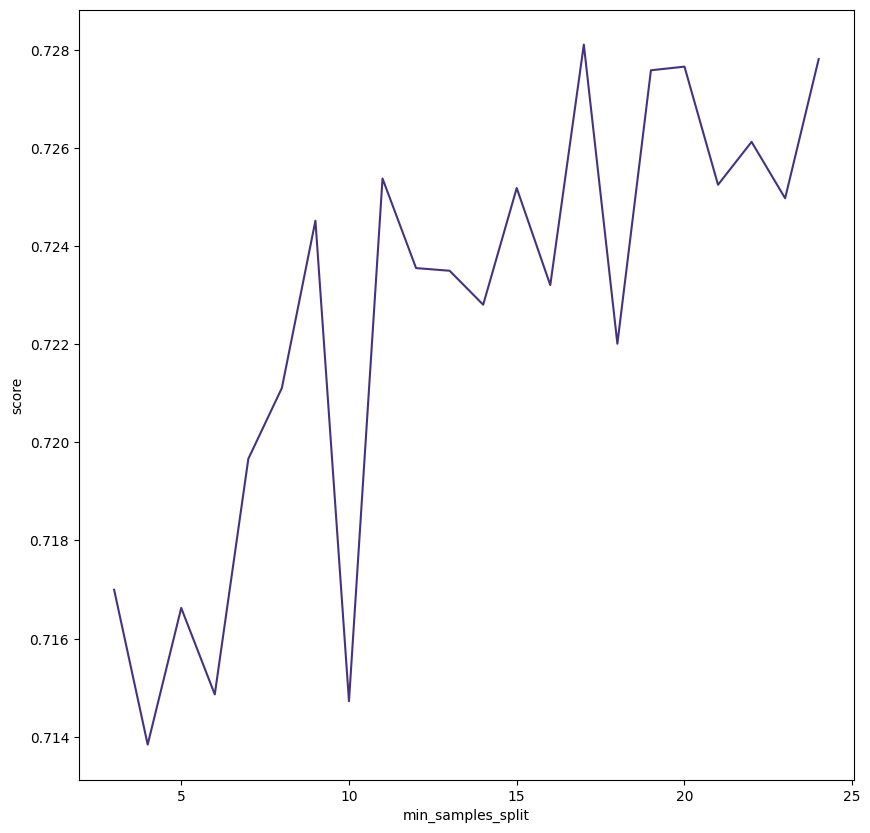

In [50]:
plt.figure(figsize=(10,10))

x_vals = range(3, 25)
y_vals = []

for i in x_vals:
  rgr = DecisionTreeRegressor(
      max_depth=13,
      min_samples_split=i,
      random_state=42
      )
  rgr.fit(X_train, y_train)
  y_vals.append(rgr.score(X_test, y_test))

plt.plot(x_vals, y_vals)
plt.xlabel('min_samples_split')
plt.ylabel('score')
plt.show()

In [51]:
x_vals[y_vals.index(max(y_vals))]

17

The min_samples_split shows how many samples should be there so that it can be splitted(questioned). The best is 12 and it is ok.

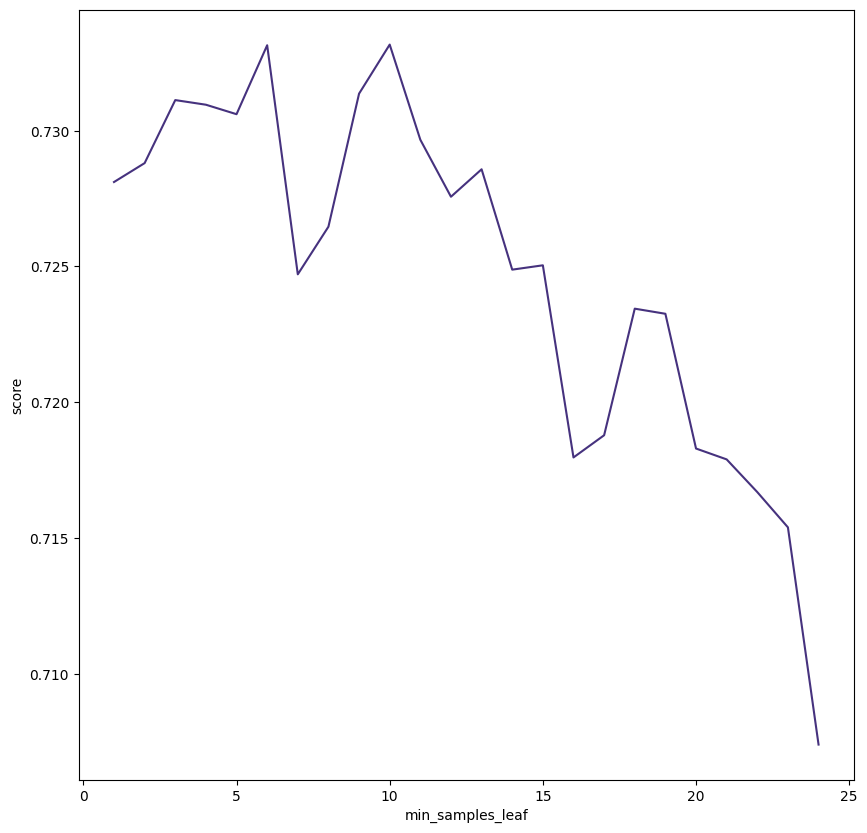

In [67]:
plt.figure(figsize=(10,10))

x_vals = range(1, 25)
y_vals = []

for i in x_vals:
  rgr = DecisionTreeRegressor(
      max_depth=13,
      min_samples_split=17,
      min_samples_leaf=i,
      random_state=42
      )
  rgr.fit(X_train, y_train)
  y_vals.append(rgr.score(X_test, y_test))

plt.plot(x_vals, y_vals)
plt.xlabel('min_samples_leaf')
plt.ylabel('score')
plt.show()

In [53]:
x_vals[y_vals.index(max(y_vals))]

4

The min_samples_leaf shows how many samples should be there so it can become a leaf. The best is 4, but it is overfitting(for each sample there would be a leaf), so I'll take 10.

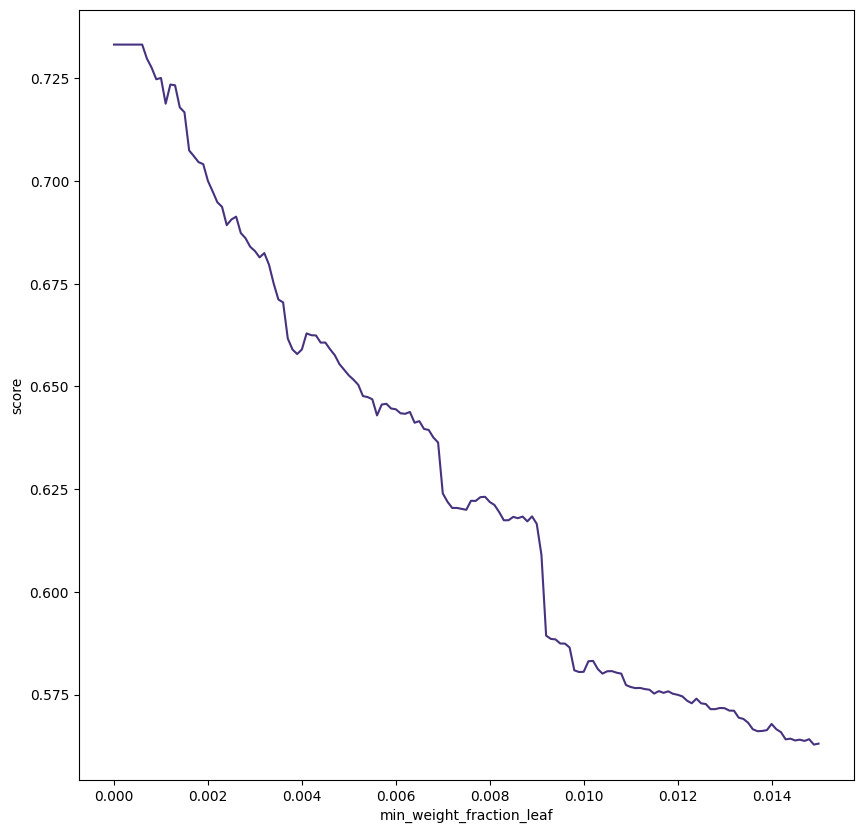

In [70]:
plt.figure(figsize=(10,10))

x_vals = [i * 0.0001 for i in range(151)]
y_vals = []

for i in x_vals:
  rgr = DecisionTreeRegressor(
      max_depth=13,
      min_samples_split=17,
      min_samples_leaf=10,
      min_weight_fraction_leaf=i,
      random_state=42
      )
  rgr.fit(X_train, y_train)
  y_vals.append(rgr.score(X_test, y_test))

plt.plot(x_vals, y_vals)
plt.xlabel('min_weight_fraction_leaf')
plt.ylabel('score')
plt.show()

In [55]:
x_vals[y_vals.index(max(y_vals))]

0.0

The min_weight_fraction_leaf shows which percent of the total number of samples a leaf must have. The score drasticaly falls when the weight is increased. The 0 may mean overfitting, so lets' go with 5e-4 - a small number, but having 18k entries => 1% is 180 samples, so let it be quite small.

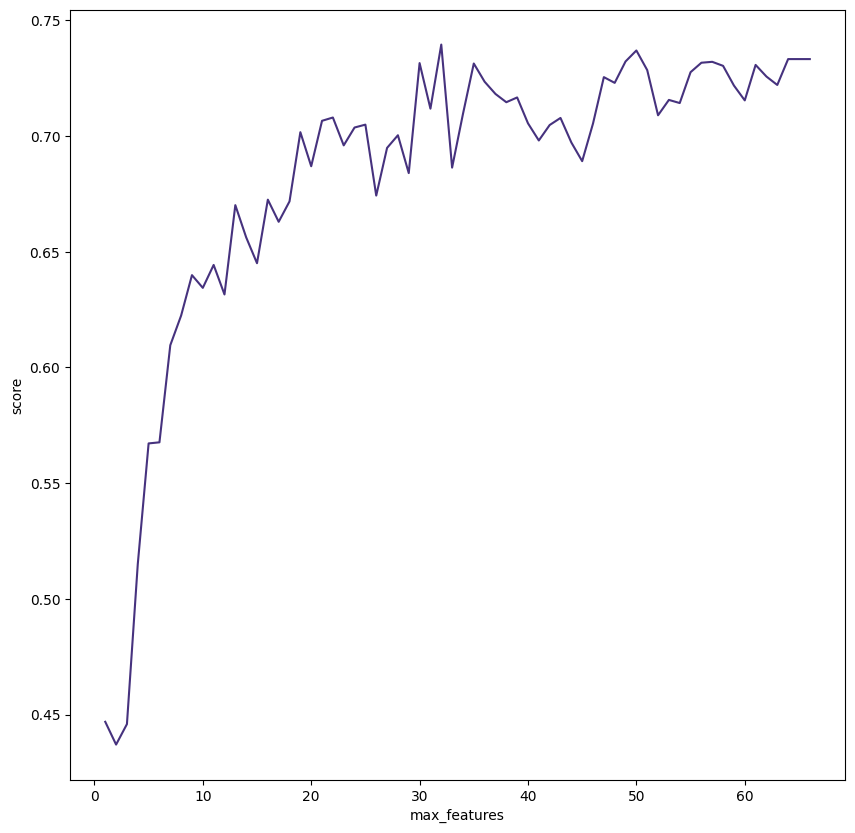

In [71]:
plt.figure(figsize=(10,10))

x_vals = range(1,len(df.columns) + 1)
y_vals = []

for i in x_vals:
  rgr = DecisionTreeRegressor(
      max_depth=13,
      min_samples_split=17,
      min_samples_leaf=10,
      min_weight_fraction_leaf=5e-4,
      max_features=i,
      random_state=42
      )
  rgr.fit(X_train, y_train)
  y_vals.append(rgr.score(X_test, y_test))

plt.plot(x_vals, y_vals)
plt.xlabel('max_features')
plt.ylabel('score')
plt.show()

In [72]:
x_vals[y_vals.index(max(y_vals[:41]))]

32

In [58]:
y_vals = []

for i in ['sqrt', 'log2']:
  rgr = DecisionTreeRegressor(
    max_depth=13,
    min_samples_split=17,
    min_samples_leaf=10,
    min_weight_fraction_leaf=5e-4,
    max_features=i,
    random_state=42
    )
  rgr.fit(X_train, y_train)
  y_vals.append(rgr.score(X_test, y_test))

print(y_vals)

[0.6353142502684845, 0.5763273157896365]


As the number of features increases, the model performance improves significantly at first. After approximately 35–40 features, the score reaches a plateau and further increases bring only minor fluctuations without substantial improvement. Therefore, selecting around 36 features provides a good trade-off between model performance and complexity, while avoiding unnecessary features that do not contribute meaningful information.

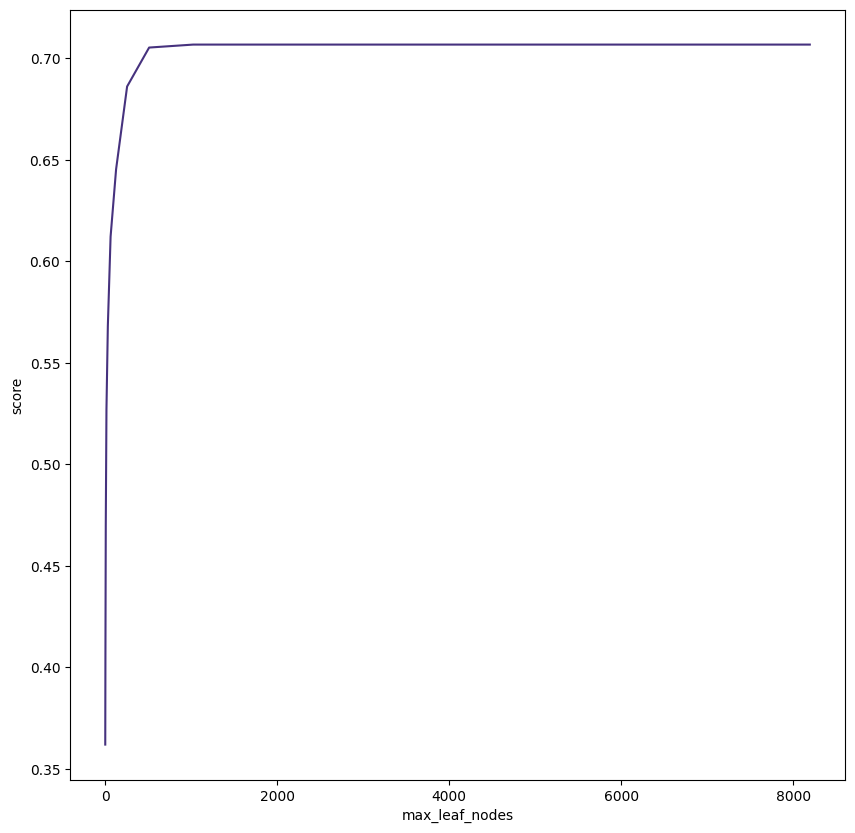

In [73]:
plt.figure(figsize=(10,10))

x_vals = [2 ** i for i in range(1, 14)]
y_vals = []

for i in x_vals:
  rgr = DecisionTreeRegressor(
      max_depth=13,
      min_samples_split=17,
      min_samples_leaf=10,
      min_weight_fraction_leaf=5e-4,
      max_features=32,
      max_leaf_nodes=i,
      random_state=42
      )
  rgr.fit(X_train, y_train)
  y_vals.append(rgr.score(X_test, y_test))

plt.plot(x_vals, y_vals)
plt.xlabel('max_leaf_nodes')
plt.ylabel('score')
plt.show()

In [60]:
x_vals[y_vals.index(max(y_vals))]

1024

The max_leaf_nodes parameter controls the maximum number of leaf nodes allowed in the decision tree, directly limiting its complexity. As the number of allowed leaf nodes increases, the model performance improves, indicating that the tree can capture more complex patterns in the data. After approximately 1024 leaf nodes, the score reaches a plateau, meaning that further increases do not provide significant performance gains. Therefore, 1024 is selected as an appropriate value, as it achieves near-maximum performance while avoiding unnecessary model complexity.

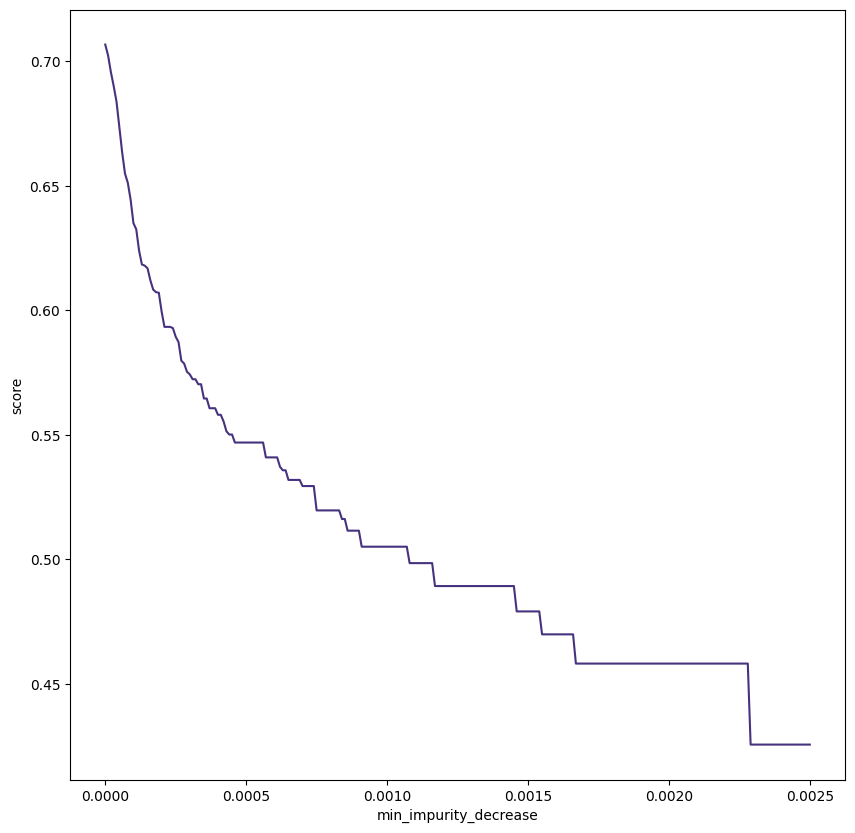

In [74]:
plt.figure(figsize=(10,10))

x_vals = [i * 0.00001 for i in range(0, 251)]
y_vals = []

for i in x_vals:
  rgr = DecisionTreeRegressor(
      max_depth=13,
      min_samples_split=17,
      min_samples_leaf=10,
      min_weight_fraction_leaf=5e-4,
      max_features=32,
      max_leaf_nodes=1024,
      min_impurity_decrease=i,
      random_state=42
      )
  rgr.fit(X_train, y_train)
  y_vals.append(rgr.score(X_test, y_test))

plt.plot(x_vals, y_vals)
plt.xlabel('min_impurity_decrease')
plt.ylabel('score')
plt.show()

In [75]:
x_vals[y_vals.index(max(y_vals))]

0.0

A node will be split if this split induces a decrease of the impurity greater than or equal to this value. The best is 0, and we're ok with it.
We won't put it further as its' default is 0.

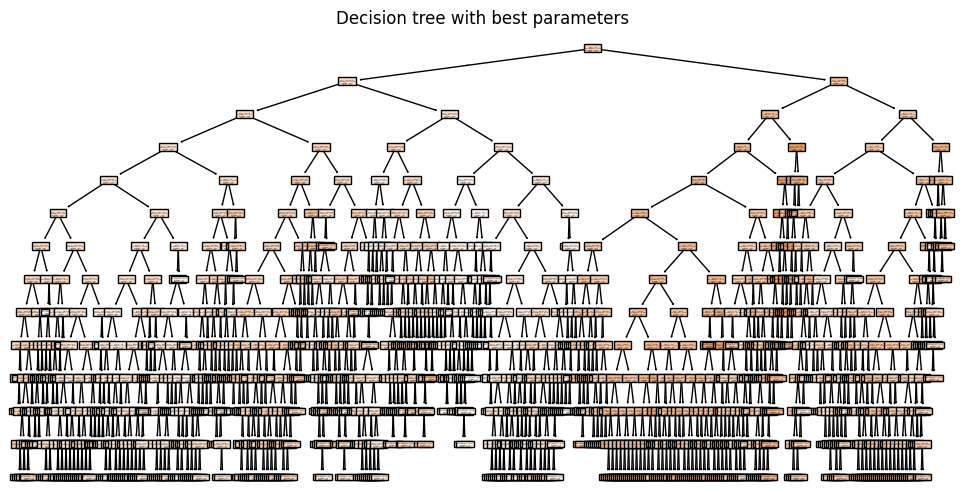

In [76]:
plt.figure(figsize=(12,6))

rgr = DecisionTreeRegressor(
    max_depth=13,
    min_samples_split=17,
    min_samples_leaf=10,
    min_weight_fraction_leaf=5e-4,
    max_features=32,
    max_leaf_nodes=1024,
    random_state=42
    )
rgr.fit(X_train, y_train)

plot_tree(rgr, filled=True)
plt.title("Decision tree with best parameters")
plt.show()

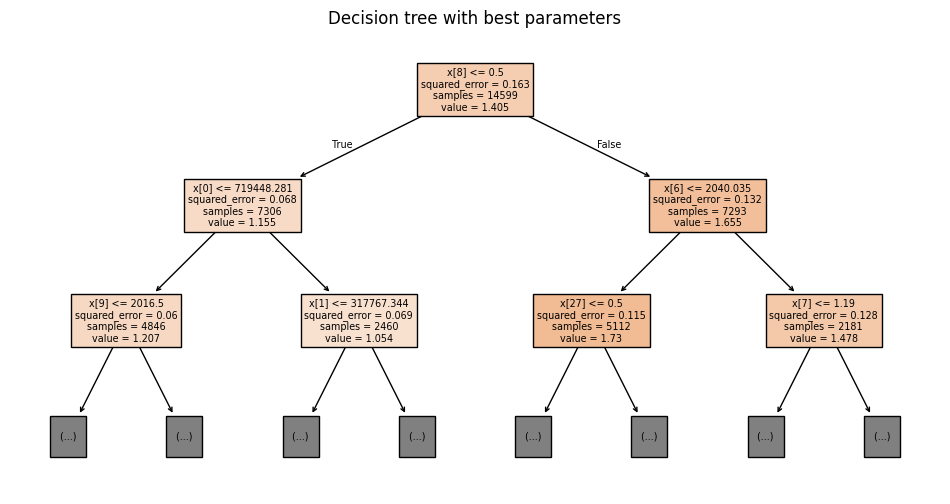

In [77]:
plt.figure(figsize=(12,6))
plot_tree(rgr, filled=True, max_depth=2)
plt.title("Decision tree with best parameters")
plt.show()

In [78]:
print(rgr.score(X_test, y_test))

0.7066703371897756


This structure shows that the most important feature is feature 8 - Large Bags, and then comes 0 - Date, and 6 - Total Bags.